In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'darkgrid')

# Load sequence IDs and lengths
all_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
kmers_mmap = np.load('Runs/kmers_SFE_SE_1.npy', mmap_mode = 'r')
all_lengths = kmers_mmap[:, 0]

# Filter for >= 100 kbp
MIN_LENGTH = 100_000
long_mask = all_lengths >= MIN_LENGTH
filtered_ids = all_ids[long_mask]
filtered_lengths = all_lengths[long_mask]

# Build id -> length mapping
id_to_length = dict(zip(filtered_ids, filtered_lengths))

print(f'Total sequences >= 100 kbp: {len(filtered_ids):,}')
print(f'Length range: {filtered_lengths.min()/1000:.0f} - {filtered_lengths.max()/1000:.0f} kbp')

Total sequences >= 100 kbp: 154,040
Length range: 100 - 10208 kbp


In [32]:
# Parse MCL I=3.0 clusters
cluster_file = 'Runs/MCL_100_NCBI_5_d5/mcl_I3.0.clusters'
clusters = []
with open(cluster_file) as f:
    for line in f:
        members = line.strip().split('\t')
        clusters.append(members)

cluster_sizes = np.array([len(c) for c in clusters])
singletons = [c[0] for c in clusters if len(c) == 1]

print(f'Total clusters: {len(clusters):,}')
print(f'Singletons: {len(singletons):,} ({len(singletons)/len(clusters)*100:.1f}%)')
print(f'Non-singleton clusters: {len(clusters) - len(singletons):,}')
print(f'Total sequences in clusters: {sum(cluster_sizes):,}')

Total clusters: 12,123
Singletons: 710 (5.9%)
Non-singleton clusters: 11,413
Total sequences in clusters: 133,724



Singleton length statistics (kbp):
  Min:    100
  Median: 197
  Mean:   233
  Max:    4104


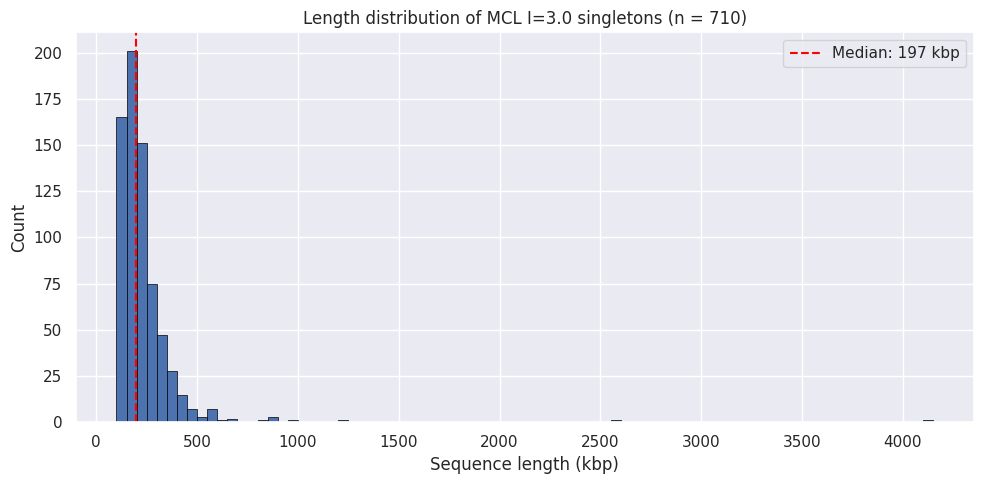

In [33]:
# Get lengths for singletons
singleton_lengths = np.array([id_to_length[s] for s in singletons if s in id_to_length])
missing = len(singletons) - len(singleton_lengths)
if missing:
    print(f'Warning: {missing} singletons not found in id_to_length')

print(f'\nSingleton length statistics (kbp):')
print(f'  Min:    {singleton_lengths.min()/1000:.0f}')
print(f'  Median: {np.median(singleton_lengths)/1000:.0f}')
print(f'  Mean:   {singleton_lengths.mean()/1000:.0f}')
print(f'  Max:    {singleton_lengths.max()/1000:.0f}')

# Plot
fig, ax = plt.subplots(figsize = (10, 5))

bins = np.arange(100, singleton_lengths.max() / 1000 + 50, 50)
ax.hist(singleton_lengths / 1000, bins = bins, edgecolor = 'black', linewidth = 0.5)
ax.set_xlabel('Sequence length (kbp)')
ax.set_ylabel('Count')
ax.set_title(f'Length distribution of MCL I=3.0 singletons (n = {len(singleton_lengths):,})')
ax.axvline(np.median(singleton_lengths) / 1000, color = 'red', linestyle = '--',
           label = f'Median: {np.median(singleton_lengths)/1000:.0f} kbp')
ax.legend()
plt.tight_layout()
plt.show()

In [34]:
# Singletons above 750 kbp
long_singletons = [(s, id_to_length[s]) for s in singletons if id_to_length[s] > 750_000]
long_singletons.sort(key = lambda x: -x[1])
for sid, length in long_singletons:
    print(f'{sid}\t{length/1000:.0f} kbp')

SFE_6_S_c_86643	4104 kbp
SFE_3_S_c_18414	2566 kbp
SFE_2_S_c_44668	1243 kbp
SE_19_c_48401	998 kbp
SE_4_c_88831	894 kbp
SFE_8_S_c_12430	874 kbp
SFE_8_S_c_53232	858 kbp
SFE_3_S_c_3378	812 kbp


In [35]:
# Load NCBI embeddings (embedded through NCBI_5 encoder)
ncbi_embed_all = np.load('Runs/embed_NCBI_5_NCBI_5.npy', mmap_mode = 'r')
ncbi_ids_all = np.loadtxt('Runs/ids_NCBI_5.txt', dtype = str)
ncbi_lengths = ncbi_embed_all[:, 0]
ncbi_mask = ncbi_lengths >= MIN_LENGTH
ncbi_ids = ncbi_ids_all[ncbi_mask]
ncbi_embed = np.array(ncbi_embed_all[ncbi_mask, 1:])  # 384-dim, materialize

# Build set of IDs in the graph (from cluster file) and cluster mapping
graph_ids = set()
id_to_cluster = {}
for ci, c in enumerate(clusters):
    for member in c:
        graph_ids.add(member)
        id_to_cluster[member] = ci

# Find row indices of graph nodes in the full marine ID list
id_to_row = {name: i for i, name in enumerate(all_ids) if name in graph_ids}
graph_rows = np.array(sorted(id_to_row.values()))  # sorted for sequential mmap reads

# Load marine embeddings only for graph nodes (sorted for fast mmap access)
marine_embed_all = np.load('Runs/embed_SFE_SE_1_NCBI_5.npy', mmap_mode = 'r')
marine_graph_embed = np.array(marine_embed_all[graph_rows, 1:])
marine_graph_ids = all_ids[graph_rows]

print(f'NCBI sequences >= 100 kbp: {len(ncbi_ids):,}')
print(f'Marine graph nodes loaded: {len(marine_graph_ids):,}')
print(f'Embedding dim: {ncbi_embed.shape[1]}')

NCBI sequences >= 100 kbp: 175,213
Marine graph nodes loaded: 133,724
Embedding dim: 384


In [36]:
import time

# For each NCBI sequence, find its nearest marine graph node
# Uses ||a-b||^2 = ||a||^2 + ||b||^2 - 2*a@b.T (BLAS-accelerated, all 32 cores)
D_THRESHOLD = 5.0  # same as graph construction
BATCH_SIZE = 10_000

# Precompute squared norms for marine graph embeddings
marine_sq_norms = np.sum(marine_graph_embed ** 2, axis = 1)  # (133K,)

nearest_dist = np.full(len(ncbi_ids), np.inf)
nearest_cluster = np.full(len(ncbi_ids), -1, dtype = int)

t0 = time.time()
for i in range(0, len(ncbi_ids), BATCH_SIZE):
    batch = ncbi_embed[i:i + BATCH_SIZE]
    batch_sq_norms = np.sum(batch ** 2, axis = 1, keepdims = True)  # (batch, 1)
    # Squared Euclidean distances via BLAS matrix multiply
    sq_dists = batch_sq_norms + marine_sq_norms - 2.0 * batch @ marine_graph_embed.T
    np.maximum(sq_dists, 0, out = sq_dists)  # clamp numerical noise
    min_idx = sq_dists.argmin(axis = 1)
    min_sq_dist = sq_dists[np.arange(len(batch)), min_idx]
    nearest_dist[i:i + len(batch)] = np.sqrt(min_sq_dist)
    nearest_cluster[i:i + len(batch)] = [id_to_cluster[marine_graph_ids[j]] for j in min_idx]
    elapsed = time.time() - t0
    done = i + len(batch)
    rate = done / elapsed
    eta = (len(ncbi_ids) - done) / rate
    print(f'  {done:,} / {len(ncbi_ids):,}  ({elapsed:.0f}s elapsed, ~{eta:.0f}s remaining)')

# Apply distance threshold
within_threshold = nearest_dist <= D_THRESHOLD
ncbi_assigned_clusters = set(nearest_cluster[within_threshold])

print(f'\nNCBI sequences with nearest marine neighbor <= d={D_THRESHOLD}: {within_threshold.sum():,} / {len(ncbi_ids):,} ({within_threshold.mean()*100:.1f}%)')
print(f'Clusters with at least one NCBI representative: {len(ncbi_assigned_clusters):,} / {len(clusters):,} ({len(ncbi_assigned_clusters)/len(clusters)*100:.1f}%)')
print(f'Clusters WITHOUT any NCBI representative: {len(clusters) - len(ncbi_assigned_clusters):,}')

  10,000 / 175,213  (2s elapsed, ~29s remaining)
  20,000 / 175,213  (3s elapsed, ~27s remaining)
  30,000 / 175,213  (5s elapsed, ~25s remaining)
  40,000 / 175,213  (7s elapsed, ~23s remaining)
  50,000 / 175,213  (8s elapsed, ~21s remaining)
  60,000 / 175,213  (10s elapsed, ~19s remaining)
  70,000 / 175,213  (12s elapsed, ~18s remaining)
  80,000 / 175,213  (14s elapsed, ~16s remaining)
  90,000 / 175,213  (15s elapsed, ~14s remaining)
  100,000 / 175,213  (17s elapsed, ~13s remaining)
  110,000 / 175,213  (19s elapsed, ~11s remaining)
  120,000 / 175,213  (20s elapsed, ~9s remaining)
  130,000 / 175,213  (22s elapsed, ~8s remaining)
  140,000 / 175,213  (24s elapsed, ~6s remaining)
  150,000 / 175,213  (25s elapsed, ~4s remaining)
  160,000 / 175,213  (27s elapsed, ~3s remaining)
  170,000 / 175,213  (29s elapsed, ~1s remaining)
  175,213 / 175,213  (29s elapsed, ~0s remaining)

NCBI sequences with nearest marine neighbor <= d=5.0: 7,348 / 175,213 (4.2%)
Clusters with at least on

In [37]:
singleton_clusters = {id_to_cluster[s] for s in singletons}
ncbi_singletons = ncbi_assigned_clusters & singleton_clusters
print(f'NCBI-assigned clusters that are singletons: {len(ncbi_singletons)} / {len(ncbi_assigned_clusters)}')

NCBI-assigned clusters that are singletons: 6 / 325


NCBI-matched cluster sizes (n = 325):
  Min:    1
  Median: 21
  Mean:   35
  Max:    158
  Total sequences in these clusters: 11,479


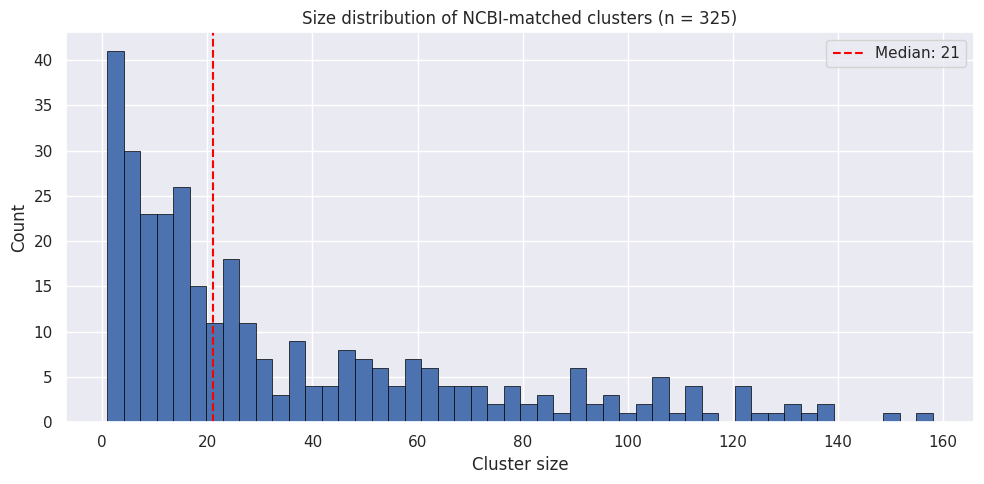

In [38]:
# Cluster size distribution for NCBI-matched clusters
ncbi_cluster_sizes = np.array([cluster_sizes[ci] for ci in ncbi_assigned_clusters])

print(f'NCBI-matched cluster sizes (n = {len(ncbi_cluster_sizes)}):')
print(f'  Min:    {ncbi_cluster_sizes.min()}')
print(f'  Median: {np.median(ncbi_cluster_sizes):.0f}')
print(f'  Mean:   {ncbi_cluster_sizes.mean():.0f}')
print(f'  Max:    {ncbi_cluster_sizes.max()}')
print(f'  Total sequences in these clusters: {ncbi_cluster_sizes.sum():,}')

fig, ax = plt.subplots(figsize = (10, 5))
ax.hist(ncbi_cluster_sizes, bins = 50, edgecolor = 'black', linewidth = 0.5)
ax.set_xlabel('Cluster size')
ax.set_ylabel('Count')
ax.set_title(f'Size distribution of NCBI-matched clusters (n = {len(ncbi_cluster_sizes)})')
ax.axvline(np.median(ncbi_cluster_sizes), color = 'red', linestyle = '--',
           label = f'Median: {np.median(ncbi_cluster_sizes):.0f}')
ax.legend()
plt.tight_layout()
plt.show()

Unmatched cluster sizes (n = 11,798):
  Min:    1
  Median: 3
  Mean:   10
  Max:    180
  Total sequences: 122,245


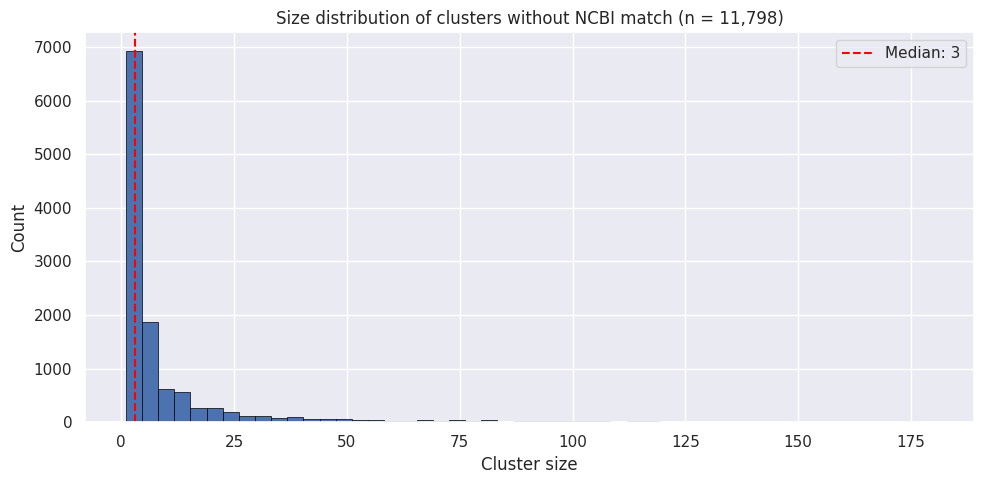

In [39]:
# Size distribution of clusters WITHOUT NCBI match
unmatched = [ci for ci in range(len(clusters)) if ci not in ncbi_assigned_clusters]
unmatched_sizes = np.array([cluster_sizes[ci] for ci in unmatched])

print(f'Unmatched cluster sizes (n = {len(unmatched_sizes):,}):')
print(f'  Min:    {unmatched_sizes.min()}')
print(f'  Median: {np.median(unmatched_sizes):.0f}')
print(f'  Mean:   {unmatched_sizes.mean():.0f}')
print(f'  Max:    {unmatched_sizes.max()}')
print(f'  Total sequences: {unmatched_sizes.sum():,}')

fig, ax = plt.subplots(figsize = (10, 5))
ax.hist(unmatched_sizes, bins = 50, edgecolor = 'black', linewidth = 0.5)
ax.set_xlabel('Cluster size')
ax.set_ylabel('Count')
ax.set_title(f'Size distribution of clusters without NCBI match (n = {len(unmatched_sizes):,})')
ax.axvline(np.median(unmatched_sizes), color = 'red', linestyle = '--',
           label = f'Median: {np.median(unmatched_sizes):.0f}')
ax.legend()
plt.tight_layout()
plt.show()

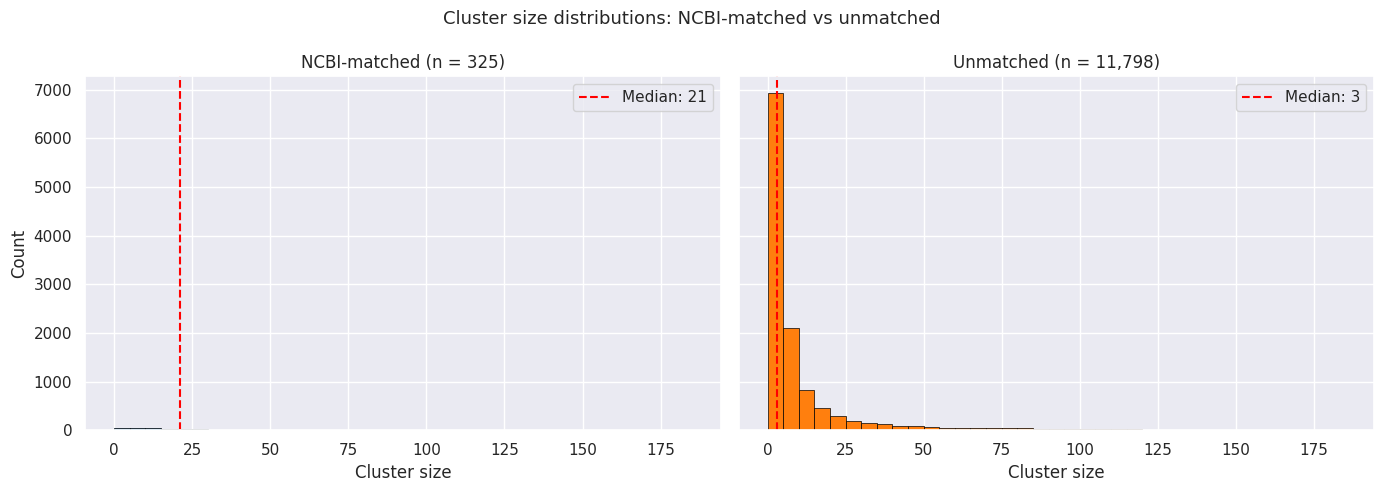

In [40]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), sharey = True)

max_size = max(ncbi_cluster_sizes.max(), unmatched_sizes.max())
bins = np.arange(0, max_size + 10, 5)

ax1.hist(ncbi_cluster_sizes, bins = bins, edgecolor = 'black', linewidth = 0.5, color = 'tab:blue')
ax1.axvline(np.median(ncbi_cluster_sizes), color = 'red', linestyle = '--',
            label = f'Median: {np.median(ncbi_cluster_sizes):.0f}')
ax1.set_xlabel('Cluster size')
ax1.set_ylabel('Count')
ax1.set_title(f'NCBI-matched (n = {len(ncbi_cluster_sizes)})')
ax1.legend()

ax2.hist(unmatched_sizes, bins = bins, edgecolor = 'black', linewidth = 0.5, color = 'tab:orange')
ax2.axvline(np.median(unmatched_sizes), color = 'red', linestyle = '--',
            label = f'Median: {np.median(unmatched_sizes):.0f}')
ax2.set_xlabel('Cluster size')
ax2.set_title(f'Unmatched (n = {len(unmatched_sizes):,})')
ax2.legend()

fig.suptitle('Cluster size distributions: NCBI-matched vs unmatched', fontsize = 13)
plt.tight_layout()
plt.show()

In [41]:
# Phase 2: Load NCBI taxonomy and assign consensus taxonomy to clusters
import csv
from collections import defaultdict, Counter

RANKS = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# Load taxonomy TSV
ncbi_tax = {}  # ncbi_id -> {rank: name}
with open('Runs/taxonomy/ncbi_taxonomy.tsv') as f:
    reader = csv.DictReader(f, delimiter = '\t')
    for row in reader:
        ncbi_tax[row['ncbi_id']] = {r: row[r] for r in RANKS if row[r]}

print(f'Loaded taxonomy for {len(ncbi_tax):,} NCBI sequences')
print(f'Example: {list(ncbi_tax.items())[0]}')

Loaded taxonomy for 655,640 NCBI sequences
Example: ('NCBI_CP176574', {'domain': 'Bacteria', 'phylum': 'Mycoplasmatota', 'class': 'Mollicutes', 'order': 'Acholeplasmatales', 'family': 'Acholeplasmataceae', 'genus': 'Candidatus Phytoplasma', 'species': 'Candidatus Phytoplasma sacchari'})


In [42]:
# Group NCBI hits by cluster (unweighted majority vote)
# For each cluster: collect all NCBI sequences within d=5.0 with their taxonomy
cluster_ncbi_hits = defaultdict(list)  # cluster_idx -> [(ncbi_id, distance)]

for i in range(len(ncbi_ids)):
    if within_threshold[i]:
        cluster_ncbi_hits[nearest_cluster[i]].append((ncbi_ids[i], nearest_dist[i]))

# Build consensus taxonomy for each matched cluster
cluster_taxonomy = {}  # cluster_idx -> {rank: (name, agreement_fraction, n_hits)}

for ci, hits in cluster_ncbi_hits.items():
    n_hits = len(hits)
    consensus = {}
    for rank in RANKS:
        # Count taxa at this rank across all hits
        taxa = [ncbi_tax.get(nid, {}).get(rank, '') for nid, _ in hits]
        taxa = [t for t in taxa if t]  # remove empty
        if not taxa:
            break  # stop at first rank with no data
        counts = Counter(taxa)
        top_taxon, top_count = counts.most_common(1)[0]
        agreement = top_count / len(taxa)
        consensus[rank] = (top_taxon, agreement, len(taxa))
    cluster_taxonomy[ci] = consensus

# Summary
print(f'Clusters with taxonomy: {len(cluster_taxonomy)}')
n_by_rank = {r: sum(1 for ct in cluster_taxonomy.values() if r in ct) for r in RANKS}
for r in RANKS:
    print(f'  {r:12s}: {n_by_rank[r]:,} clusters')

# Show agreement distribution at phylum level
phylum_agreements = [ct['phylum'][1] for ct in cluster_taxonomy.values() if 'phylum' in ct]
print(f'\nPhylum-level agreement: mean={np.mean(phylum_agreements):.1%}, '
      f'median={np.median(phylum_agreements):.1%}, '
      f'100%={sum(1 for a in phylum_agreements if a == 1.0)}/{len(phylum_agreements)}')

Clusters with taxonomy: 325
  domain      : 325 clusters
  phylum      : 325 clusters
  class       : 324 clusters
  order       : 321 clusters
  family      : 320 clusters
  genus       : 320 clusters
  species     : 320 clusters

Phylum-level agreement: mean=99.9%, median=100.0%, 100%=323/325


In [43]:
# Propagate taxonomy to all marine contigs in matched clusters
# Assign taxonomy at the deepest rank where agreement >= 80%
AGREEMENT_THRESHOLD = 0.8

contig_taxonomy = {}  # marine_id -> {rank: name, ..., 'confidence': tier, 'depth': rank}

for ci, consensus in cluster_taxonomy.items():
    # Find deepest rank with sufficient agreement
    assigned = {}
    deepest_rank = None
    for rank in RANKS:
        if rank not in consensus:
            break
        taxon, agreement, n_hits = consensus[rank]
        if agreement >= AGREEMENT_THRESHOLD:
            assigned[rank] = taxon
            deepest_rank = rank
        else:
            break  # stop at first disagreement

    if not assigned:
        continue

    # Assign to all contigs in this cluster
    for member in clusters[ci]:
        contig_taxonomy[member] = {
            **assigned,
            '_depth': deepest_rank,
            '_cluster': ci,
            '_cluster_size': cluster_sizes[ci],
            '_n_ncbi_hits': len(cluster_ncbi_hits[ci]),
            '_confidence': 'A'  # Tier A: direct NCBI match
        }

# Summary
print(f'Marine contigs with taxonomy (>= {AGREEMENT_THRESHOLD:.0%} agreement):')
print(f'  {len(contig_taxonomy):,} / {sum(cluster_sizes):,} ({len(contig_taxonomy)/sum(cluster_sizes)*100:.1f}%)')
print(f'\nDepth of assignment:')
depth_counts = Counter(v['_depth'] for v in contig_taxonomy.values())
for rank in RANKS:
    if rank in depth_counts:
        print(f'  {rank:12s}: {depth_counts[rank]:,} contigs')

print(f'\nPhylum breakdown:')
phylum_counts = Counter(v.get('phylum', '?') for v in contig_taxonomy.values())
for phylum, count in phylum_counts.most_common(15):
    print(f'  {phylum:30s}: {count:,}')

Marine contigs with taxonomy (>= 80% agreement):
  11,479 / 133,724 (8.6%)

Depth of assignment:
  domain      : 6 contigs
  phylum      : 112 contigs
  class       : 110 contigs
  order       : 640 contigs
  family      : 1,415 contigs
  genus       : 4,039 contigs
  species     : 5,157 contigs

Phylum breakdown:
  Pseudomonadota                : 4,807
  Bacteroidota                  : 3,230
  Actinomycetota                : 834
  Verrucomicrobiota             : 653
  Cyanobacteriota               : 629
  Thermodesulfobacteriota       : 474
  Planctomycetota               : 338
  Nitrososphaerota              : 164
  Kiritimatiellota              : 119
  Spirochaetota                 : 85
  Campylobacterota              : 49
  Chloroflexota                 : 36
  Gemmatimonadota               : 26
  Mycoplasmatota                : 17
  Bacillota                     : 12


In [44]:
# Write taxonomy assignments to TSV
output_file = 'Runs/taxonomy/cluster_taxonomy.tsv'
with open(output_file, 'w') as f:
    header = ['contig_id', 'cluster', 'cluster_size', 'n_ncbi_hits',
              'confidence', 'depth'] + RANKS
    f.write('\t'.join(header) + '\n')
    for contig_id, tax in sorted(contig_taxonomy.items(), key = lambda x: x[1]['_cluster']):
        fields = [
            contig_id,
            str(tax['_cluster']),
            str(tax['_cluster_size']),
            str(tax['_n_ncbi_hits']),
            tax['_confidence'],
            tax['_depth'],
        ]
        for rank in RANKS:
            fields.append(tax.get(rank, ''))
        f.write('\t'.join(fields) + '\n')

print(f'Written {len(contig_taxonomy):,} assignments to {output_file}')

Written 11,479 assignments to Runs/taxonomy/cluster_taxonomy.tsv


In [45]:
# Phase 3: Load GTDB-Tk results from both servers
import csv
from pathlib import Path

GTDB_RANKS = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

def parse_gtdbtk_classification(classif_str):
    """Parse 'd__Bacteria;p__Pseudo...' into {rank: name} dict."""
    prefix_to_rank = {
        'd__': 'domain', 'p__': 'phylum', 'c__': 'class',
        'o__': 'order', 'f__': 'family', 'g__': 'genus', 's__': 'species'
    }
    result = {}
    if not classif_str or classif_str.startswith('Unclassified'):
        return result
    for part in classif_str.split(';'):
        prefix = part[:3]
        name = part[3:].strip()
        if prefix in prefix_to_rank and name:
            result[prefix_to_rank[prefix]] = name
    return result

# Load all 4 summary files
gtdbtk = {}  # contig_id -> {rank: name, '_classification': str, '_method': str, '_warnings': str}
for subdir in ['SFE_gtdbtk_output', 'SE_gtdbtk_output']:
    for fname in ['gtdbtk.bac120.summary.tsv', 'gtdbtk.ar53.summary.tsv']:
        path = Path('Runs/taxonomy') / subdir / fname
        with open(path) as f:
            reader = csv.DictReader(f, delimiter = '\t')
            for row in reader:
                genome = row['user_genome']
                classif = row['classification']
                parsed = parse_gtdbtk_classification(classif)
                gtdbtk[genome] = {
                    **parsed,
                    '_classification': classif,
                    '_method': row.get('classification_method', ''),
                    '_warnings': row.get('warnings', ''),
                    '_msa_percent': row.get('msa_percent', ''),
                    '_note': row.get('note', ''),
                }

# Categorize
classified = {k: v for k, v in gtdbtk.items() if 'domain' in v}
unclassified_with_domain = {k: v for k, v in gtdbtk.items()
                            if 'domain' not in v
                            and ('Unclassified Bacteria' in v['_classification']
                                 or 'Unclassified Archaea' in v['_classification'])}
no_markers = {k: v for k, v in gtdbtk.items()
              if v['_classification'] == 'Unclassified'}

print(f'Total GTDB-Tk results: {len(gtdbtk):,}')
print(f'  Classified (at least domain): {len(classified):,} ({len(classified)/len(gtdbtk)*100:.1f}%)')
print(f'  Unclassified Bacteria/Archaea (markers found, insufficient): '
      f'{len(unclassified_with_domain):,} ({len(unclassified_with_domain)/len(gtdbtk)*100:.1f}%)')
print(f'  No markers at all: {len(no_markers):,} ({len(no_markers)/len(gtdbtk)*100:.1f}%)')

# Verify categories are exhaustive
accounted = len(classified) + len(unclassified_with_domain) + len(no_markers)
if accounted != len(gtdbtk):
    print(f'  WARNING: {len(gtdbtk) - accounted:,} contigs unaccounted for')

print(f'\nClassified by domain:')
domain_counts = Counter(v.get('domain', '?') for v in classified.values())
for d, c in domain_counts.most_common():
    print(f'  {d}: {c:,}')
print(f'\nClassified by phylum (top 15):')
phylum_counts = Counter(v.get('phylum', '?') for v in classified.values())
for p, c in phylum_counts.most_common(15):
    print(f'  {p:35s}: {c:,}')

Total GTDB-Tk results: 154,041
  Classified (at least domain): 26,841 (17.4%)
  Unclassified Bacteria/Archaea (markers found, insufficient): 80,893 (52.5%)
  No markers at all: 46,307 (30.1%)

Classified by domain:
  Bacteria: 25,323
  Archaea: 1,518

Classified by phylum (top 15):
  Pseudomonadota                     : 9,930
  Bacteroidota                       : 5,117
  Actinomycetota                     : 3,849
  Verrucomicrobiota                  : 1,253
  Nanobdellota                       : 1,080
  Patescibacteriota                  : 791
  Planctomycetota                    : 777
  Cyanobacteriota                    : 736
  Chloroflexota                      : 413
  Bacillota                          : 260
  Desulfobacterota                   : 228
  Thermoplasmatota                   : 215
  Marinisomatota                     : 214
  Latescibacterota                   : 172
  Bacteroidota_A                     : 162


In [46]:
# Phase 2 vs Phase 3: Compare embedding-based vs GTDB-Tk taxonomy
# For contigs that have BOTH assignments, check agreement at each rank
# Note: Phase 2 uses NCBI taxonomy, Phase 3 uses GTDB taxonomy — some name differences expected

# Known NCBI-to-GTDB phylum mappings where names differ
NCBI_TO_GTDB_PHYLUM = {
    'Nitrososphaerota': 'Thermoproteota',  # GTDB puts Nitrososphaeria under Thermoproteota
    'Thermodesulfobacteriota': 'Desulfobacterota',  # GTDB uses Desulfobacterota
}

both = set(contig_taxonomy.keys()) & set(classified.keys())
print(f'Contigs with BOTH Phase 2 and Phase 3 classification: {len(both):,}')
print(f'  Phase 2 total: {len(contig_taxonomy):,}')
print(f'  Phase 3 classified: {len(classified):,}')
print(f'  Phase 2 only: {len(set(contig_taxonomy.keys()) - set(classified.keys())):,}')
print(f'  Phase 3 only: {len(set(classified.keys()) - set(contig_taxonomy.keys())):,}')

# Compare at each rank
print(f'\nAgreement at each rank (among {len(both):,} contigs with both):')
for rank in RANKS:
    agree = 0
    disagree = 0
    both_have = 0
    disagreements = []
    for cid in both:
        p2 = contig_taxonomy[cid].get(rank, '')
        p3 = classified[cid].get(rank, '')
        if not p2 or not p3:
            continue
        both_have += 1
        # Try direct match first, then known name mappings
        p2_mapped = NCBI_TO_GTDB_PHYLUM.get(p2, p2) if rank == 'phylum' else p2
        if p2_mapped == p3:
            agree += 1
        else:
            disagree += 1
            if len(disagreements) < 5:
                disagreements.append((cid, p2, p3))
    if both_have > 0:
        pct = agree / both_have * 100
        print(f'  {rank:12s}: {agree:,}/{both_have:,} agree ({pct:.1f}%), {disagree:,} disagree')
        if disagreements:
            for cid, p2, p3 in disagreements[:3]:
                print(f'    e.g. {cid}: Phase2={p2}, GTDB-Tk={p3}')
    else:
        print(f'  {rank:12s}: no contigs with both')

# Domain-level check (should be near-perfect)
print(f'\nDomain agreement detail:')
domain_pairs = Counter()
for cid in both:
    p2d = contig_taxonomy[cid].get('domain', '?')
    p3d = classified[cid].get('domain', '?')
    domain_pairs[(p2d, p3d)] += 1
for (p2d, p3d), count in domain_pairs.most_common():
    marker = ' ✓' if p2d == p3d else ' ✗'
    print(f'  Phase2={p2d:12s} GTDB-Tk={p3d:12s}: {count:,}{marker}')

Contigs with BOTH Phase 2 and Phase 3 classification: 2,868
  Phase 2 total: 11,479
  Phase 3 classified: 26,841
  Phase 2 only: 8,611
  Phase 3 only: 23,973

Agreement at each rank (among 2,868 contigs with both):
  domain      : 2,868/2,868 agree (100.0%), 0 disagree
  phylum      : 2,838/2,868 agree (99.0%), 30 disagree
    e.g. SE_10_c_71736: Phase2=Kiritimatiellota, GTDB-Tk=Verrucomicrobiota
    e.g. SE_5_c_11009: Phase2=Kiritimatiellota, GTDB-Tk=Verrucomicrobiota
    e.g. SFE_3_W_c_70558: Phase2=Verrucomicrobiota, GTDB-Tk=Pseudomonadota
  class       : 1,436/2,847 agree (50.4%), 1,411 disagree
    e.g. SFE_7_W_c_64056: Phase2=Betaproteobacteria, GTDB-Tk=Gammaproteobacteria
    e.g. SFE_8_W_c_48143: Phase2=Betaproteobacteria, GTDB-Tk=Gammaproteobacteria
    e.g. SFE_1_W_c_58099: Phase2=Cytophagia, GTDB-Tk=Bacteroidia
  order       : 1,455/2,811 agree (51.8%), 1,356 disagree
    e.g. SFE_4_S_c_25431: Phase2=Cellvibrionales, GTDB-Tk=Pseudomonadales
    e.g. SFE_3_S_c_30002: Phase2=V

In [47]:
# Cluster purity check: do GTDB-Tk classifications agree within MCL clusters?
# This is the key validation — if the embedding clusters are real taxonomic units,
# contigs in the same cluster should get the same GTDB-Tk classification

cluster_purity = {}  # cluster_idx -> {rank: (n_agree, n_total, dominant_taxon)}

for ci, members in enumerate(clusters):
    # Get GTDB-Tk classifications for members of this cluster
    member_tax = [classified[m] for m in members if m in classified]
    if len(member_tax) < 2:
        continue  # need at least 2 classified members to check purity

    purity = {}
    for rank in RANKS:
        taxa = [t.get(rank, '') for t in member_tax]
        taxa = [t for t in taxa if t]
        if not taxa:
            break
        counts = Counter(taxa)
        dominant, dominant_count = counts.most_common(1)[0]
        purity[rank] = (dominant_count, len(taxa), dominant)
    if purity:
        cluster_purity[ci] = purity

print(f'Clusters with >= 2 GTDB-Tk classified members: {len(cluster_purity):,}')

# Purity at each rank
print(f'\nCluster purity by rank:')
for rank in RANKS:
    purities = []
    perfect = 0
    for ci, p in cluster_purity.items():
        if rank in p:
            n_agree, n_total, _ = p[rank]
            purity_val = n_agree / n_total
            purities.append(purity_val)
            if purity_val == 1.0:
                perfect += 1
    if purities:
        print(f'  {rank:12s}: mean={np.mean(purities):.1%}, '
              f'median={np.median(purities):.1%}, '
              f'perfect={perfect}/{len(purities)} ({perfect/len(purities)*100:.1f}%)')

# Show the worst clusters (lowest phylum purity)
print(f'\nClusters with lowest phylum purity (disagreements):')
impure = []
for ci, p in cluster_purity.items():
    if 'phylum' in p:
        n_agree, n_total, dominant = p['phylum']
        purity_val = n_agree / n_total
        if purity_val < 1.0:
            impure.append((ci, purity_val, n_agree, n_total, dominant, cluster_sizes[ci]))

impure.sort(key = lambda x: x[1])
for ci, purity_val, n_agree, n_total, dominant, csize in impure[:10]:
    # Show what phyla are in this cluster
    member_phyla = [classified[m].get('phylum', '?') for m in clusters[ci] if m in classified]
    member_phyla = [p for p in member_phyla if p != '?']
    phyla_dist = Counter(member_phyla).most_common()
    print(f'  Cluster {ci} (size={csize}, {n_total} classified): '
          f'purity={purity_val:.1%} — {phyla_dist}')

Clusters with >= 2 GTDB-Tk classified members: 2,761

Cluster purity by rank:
  domain      : mean=100.0%, median=100.0%, perfect=2760/2761 (100.0%)
  phylum      : mean=99.8%, median=100.0%, perfect=2732/2753 (99.2%)
  class       : mean=99.8%, median=100.0%, perfect=2723/2750 (99.0%)
  order       : mean=99.6%, median=100.0%, perfect=2700/2742 (98.5%)
  family      : mean=99.4%, median=100.0%, perfect=2611/2663 (98.0%)
  genus       : mean=98.6%, median=100.0%, perfect=2301/2406 (95.6%)
  species     : mean=86.7%, median=100.0%, perfect=751/1186 (63.3%)

Clusters with lowest phylum purity (disagreements):
  Cluster 653 (size=48, 2 classified): purity=50.0% — [('Latescibacterota', 1), ('SAR324', 1)]
  Cluster 1500 (size=22, 2 classified): purity=50.0% — [('Pseudomonadota', 1), ('Bacteroidota', 1)]
  Cluster 1768 (size=18, 2 classified): purity=50.0% — [('Pseudomonadota', 1), ('Bacteroidota', 1)]
  Cluster 1967 (size=16, 2 classified): purity=50.0% — [('Huberarchaeota', 1), ('Asgardarc

In [48]:
# Coverage comparison: Phase 2 vs Phase 3 vs combined
# How many contigs in the MCL graph get taxonomy from each method?

graph_set = set()
for c in clusters:
    graph_set.update(c)

p2_set = set(contig_taxonomy.keys()) & graph_set
p3_set = set(classified.keys()) & graph_set
both_set = p2_set & p3_set
either_set = p2_set | p3_set
p2_only = p2_set - p3_set
p3_only = p3_set - p2_set

print(f'Taxonomy coverage of MCL graph ({len(graph_set):,} contigs):')
print(f'  Phase 2 (embedding + NCBI signposts): {len(p2_set):,} ({len(p2_set)/len(graph_set)*100:.1f}%)')
print(f'  Phase 3 (GTDB-Tk markers):            {len(p3_set):,} ({len(p3_set)/len(graph_set)*100:.1f}%)')
print(f'  Both:                                  {len(both_set):,} ({len(both_set)/len(graph_set)*100:.1f}%)')
print(f'  Either (union):                        {len(either_set):,} ({len(either_set)/len(graph_set)*100:.1f}%)')
print(f'  Phase 2 only:                          {len(p2_only):,}')
print(f'  Phase 3 only:                          {len(p3_only):,}')
print(f'  Neither:                               {len(graph_set) - len(either_set):,} ({(len(graph_set) - len(either_set))/len(graph_set)*100:.1f}%)')

# Also check: contigs NOT in graph but classified by GTDB-Tk (singletons outside graph, etc.)
all_100kbp = set(filtered_ids)
not_in_graph = all_100kbp - graph_set
p3_outside_graph = set(classified.keys()) & not_in_graph
print(f'\nContigs >= 100 kbp but NOT in MCL graph: {len(not_in_graph):,}')
print(f'  Of those, GTDB-Tk classified: {len(p3_outside_graph):,} ({len(p3_outside_graph)/len(not_in_graph)*100:.1f}%)')

Taxonomy coverage of MCL graph (133,724 contigs):
  Phase 2 (embedding + NCBI signposts): 11,479 (8.6%)
  Phase 3 (GTDB-Tk markers):            26,162 (19.6%)
  Both:                                  2,868 (2.1%)
  Either (union):                        34,773 (26.0%)
  Phase 2 only:                          8,611
  Phase 3 only:                          23,294
  Neither:                               98,951 (74.0%)

Contigs >= 100 kbp but NOT in MCL graph: 20,316
  Of those, GTDB-Tk classified: 679 (3.3%)


In [49]:
# NCBI-to-GTDB name mapping: resolve known reclassifications
# First, catalog all disagreeing pairs at each rank to understand the scope

print('=== Disagreeing pairs at each rank ===\n')
for rank in RANKS:
    pairs = Counter()
    for cid in both:
        p2 = contig_taxonomy[cid].get(rank, '')
        p3 = classified[cid].get(rank, '')
        if p2 and p3 and p2 != p3:
            pairs[(p2, p3)] += 1
    if pairs:
        print(f'{rank} ({sum(pairs.values())} disagreements, {len(pairs)} unique pairs):')
        for (ncbi_name, gtdb_name), count in pairs.most_common(20):
            print(f'  {count:5d}  NCBI: {ncbi_name:40s} → GTDB: {gtdb_name}')
        print()

=== Disagreeing pairs at each rank ===

phylum (168 disagreements, 6 unique pairs):
     71  NCBI: Nitrososphaerota                         → GTDB: Thermoproteota
     67  NCBI: Thermodesulfobacteriota                  → GTDB: Desulfobacterota
     22  NCBI: Kiritimatiellota                         → GTDB: Verrucomicrobiota
      6  NCBI: Mycoplasmatota                           → GTDB: Bacillota
      1  NCBI: Verrucomicrobiota                        → GTDB: Pseudomonadota
      1  NCBI: Bacteroidota                             → GTDB: Pseudomonadota

class (1411 disagreements, 18 unique pairs):
    444  NCBI: Betaproteobacteria                       → GTDB: Gammaproteobacteria
    431  NCBI: Flavobacteriia                           → GTDB: Bacteroidia
    237  NCBI: Cytophagia                               → GTDB: Bacteroidia
    118  NCBI: Cyanophyceae                             → GTDB: Cyanobacteriia
     91  NCBI: Opitutia                                 → GTDB: Verrucomicrobiia


In [50]:
# Apply comprehensive NCBI→GTDB name mapping and recompute agreement
# Mappings derived from the disagreement catalog above + known GTDB reclassifications

NCBI_TO_GTDB = {
    # Phylum
    ('phylum', 'Nitrososphaerota'): 'Thermoproteota',
    ('phylum', 'Thermodesulfobacteriota'): 'Desulfobacterota',
    ('phylum', 'Kiritimatiellota'): 'Verrucomicrobiota',
    ('phylum', 'Mycoplasmatota'): 'Bacillota',  # GTDB subsumes Mycoplasmatota into Bacillota

    # Class — GTDB merged several Bacteroidota classes into Bacteroidia
    ('class', 'Flavobacteriia'): 'Bacteroidia',
    ('class', 'Cytophagia'): 'Bacteroidia',
    ('class', 'Sphingobacteriia'): 'Bacteroidia',
    ('class', 'Saprospiria'): 'Bacteroidia',
    # GTDB merged Betaproteobacteria into Gammaproteobacteria
    ('class', 'Betaproteobacteria'): 'Gammaproteobacteria',
    # GTDB elevated Epsilonproteobacteria to phylum Campylobacterota
    ('class', 'Epsilonproteobacteria'): 'Campylobacteria',
    # Other known reclassifications
    ('class', 'Cyanophyceae'): 'Cyanobacteriia',
    ('class', 'Opitutia'): 'Verrucomicrobiia',
    ('class', 'Tichowtungiia'): 'Kiritimatiellia',
    ('class', 'Mollicutes'): 'Bacilli',
    ('class', 'Gemmatimonadia'): 'Gemmatimonadetes',
    ('class', 'Syntrophorhabdia'): 'DSM-4660',
    ('class', 'Planctomycetia'): 'UBA1135',
    ('class', 'Candidatius Mariprofundia'): 'Zetaproteobacteria',

    # Order — Candidatus prefix removal + GTDB rearrangements
    ('order', 'Candidatus Nanopelagicales'): 'Nanopelagicales',
    ('order', 'Candidatus Pelagibacterales'): 'Pelagibacterales',
    ('order', 'Candidatus Puniceispirillales'): 'Puniceispirillales',
    ('order', 'Alteromonadales'): 'Enterobacterales',
    ('order', 'Nitrosomonadales'): 'Burkholderiales',
    ('order', 'Cellvibrionales'): 'Pseudomonadales',
    ('order', 'Puniceicoccales'): 'Opitutales',
    ('order', 'Nitrosopumilales'): 'Nitrososphaerales',
    ('order', 'Micrococcales'): 'Actinomycetales',
    ('order', 'Nostocales'): 'Cyanobacteriales',
    ('order', 'Synechococcales'): 'PCC-6307',
    ('order', 'Chroococcales'): 'PCC-6307',
    ('order', 'Emcibacterales'): 'Sphingomonadales',
    ('order', 'Marinilabiliales'): 'Bacteroidales',
    ('order', 'Hyphomonadales'): 'Caulobacterales',
    ('order', 'Tichowtungiales'): 'Kiritimatiellales',
    ('order', 'Rhodospirillales'): 'Thalassobaculales',
    ('order', 'Hyphomicrobiales'): 'Rhizobiales',

    # Family — Candidatus prefix + mergers
    ('family', 'Candidatus Nanopelagicaceae'): 'Nanopelagicaceae',
    ('family', 'Candidatus Puniceispirillaceae'): 'Puniceispirillaceae',
    ('family', 'Candidatus Pelagibacteraceae'): 'Pelagibacteraceae',
    ('family', 'Flectobacillaceae'): 'Spirosomataceae',
    ('family', 'Comamonadaceae'): 'Burkholderiaceae',
    ('family', 'Roseobacteraceae'): 'Rhodobacteraceae',
    ('family', 'Paracoccaceae'): 'Rhodobacteraceae',
    ('family', 'Prochlorococcaceae'): 'Cyanobiaceae',
    ('family', 'Aphanizomenonaceae'): 'Nostocaceae',
    ('family', 'Sphingorhabdaceae'): 'Sphingomonadaceae',
    ('family', 'Aphanothecaceae'): 'Cyanobiaceae',
    ('family', 'Alcaligenaceae'): 'Burkholderiaceae',
    ('family', 'Erythrobacteraceae'): 'Sphingomonadaceae',
    ('family', 'Leadbetterellaceae'): 'Spirosomataceae',
    ('family', 'Roseivirgaceae'): 'Cyclobacteriaceae',
    ('family', 'Cryomorphaceae'): 'Vicingaceae',
    ('family', 'Syntrophorhabdaceae'): 'HGW-15',
    ('family', 'Pelagicoccaceae'): 'Opitutaceae',

    # Genus — Candidatus prefix + GTDB suffixed names
    ('genus', 'Candidatus Planktophila'): 'Planktophila',
    ('genus', 'Candidatus Methylopumilus'): 'Methylopumilus',
    ('genus', 'Candidatus Nanopelagicus'): 'Nanopelagicus',
    ('genus', 'Candidatus Puniceispirillum'): 'Puniceispirillum',
    ('genus', 'Candidatus Pelagibacter'): 'Pelagibacter',
    ('genus', 'Candidatus Paraluminiphilus'): 'Luminiphilus',
    ('genus', 'Candidatus Nitrosomarinus'): 'Nitrosopumilus',
}

# Also handle Candidatus prefix generically and GTDB _A/_B suffixes
def map_name(rank, ncbi_name, gtdb_name):
    """Map NCBI name to GTDB equivalent. Returns True if they match after mapping."""
    # Explicit mapping
    mapped = NCBI_TO_GTDB.get((rank, ncbi_name), ncbi_name)
    if mapped == gtdb_name:
        return True
    # Strip 'Candidatus ' prefix
    if mapped.startswith('Candidatus ') and mapped[11:] == gtdb_name:
        return True
    # GTDB suffix (_A, _B, etc.) — NCBI name matches GTDB base name
    if '_' in gtdb_name and gtdb_name.rsplit('_', 1)[0] == mapped:
        return True
    return False

# Recompute agreement with mapping
print('=== Agreement after NCBI→GTDB name mapping ===\n')
print(f'{"Rank":12s} {"Raw agree":>10s} {"Mapped agree":>13s} {"Genuine disagree":>17s} {"Total":>7s}')
print('-' * 65)
for rank in RANKS:
    raw_agree = 0
    mapped_agree = 0
    genuine_disagree = 0
    total = 0
    genuine_examples = []
    for cid in both:
        p2 = contig_taxonomy[cid].get(rank, '')
        p3 = classified[cid].get(rank, '')
        if not p2 or not p3:
            continue
        total += 1
        if p2 == p3:
            raw_agree += 1
            mapped_agree += 1
        elif map_name(rank, p2, p3):
            mapped_agree += 1
        else:
            genuine_disagree += 1
            if len(genuine_examples) < 3:
                genuine_examples.append((cid, p2, p3))
    if total > 0:
        raw_pct = raw_agree / total * 100
        mapped_pct = mapped_agree / total * 100
        print(f'{rank:12s} {raw_agree:>5d}/{total:<5d} {mapped_agree:>5d}/{total:<5d} '
              f'({mapped_pct:.1f}%) {genuine_disagree:>5d} ({genuine_disagree/total*100:.2f}%)')
        if genuine_examples:
            for cid, p2, p3 in genuine_examples:
                print(f'  → {cid}: Phase2={p2} vs GTDB-Tk={p3}')

=== Agreement after NCBI→GTDB name mapping ===

Rank          Raw agree  Mapped agree  Genuine disagree   Total
-----------------------------------------------------------------
domain        2868/2868   2868/2868  (100.0%)     0 (0.00%)
phylum        2700/2868   2866/2868  (99.9%)     2 (0.07%)
  → SFE_3_W_c_70558: Phase2=Verrucomicrobiota vs GTDB-Tk=Pseudomonadota
  → SE_19_c_24757: Phase2=Bacteroidota vs GTDB-Tk=Pseudomonadota
class         1436/2847   2844/2847  (99.9%)     3 (0.11%)
  → SFE_3_W_c_70558: Phase2=Opitutia vs GTDB-Tk=Gammaproteobacteria
  → SE_19_c_24757: Phase2=Flavobacteriia vs GTDB-Tk=Alphaproteobacteria
  → SFE_4_S_c_9785: Phase2=Gammaproteobacteria vs GTDB-Tk=Alphaproteobacteria
order         1455/2811   2629/2811  (93.5%)   182 (6.47%)
  → SFE_3_S_c_30002: Phase2=Vibrionales vs GTDB-Tk=PS1
  → SE_7_c_186809: Phase2=Hyphomicrobiales vs GTDB-Tk=Reyranellales
  → SFE_5_S_c_7912: Phase2=Vibrionales vs GTDB-Tk=PS1
family        1522/2627   2466/2627  (93.9%)   161 (6

In [51]:
# Phase 4: Load geNomad results (virus + plasmid classification)
# geNomad was run on ALL contigs (not just >= 100 kbp) on 2025-12-12
import csv

GENOMAD_DIR = 'Runs/taxonomy/genomad_summary'

# Load virus summary
virus = {}  # contig_id -> {score, fdr, n_hallmarks, taxonomy, length}
with open(f'{GENOMAD_DIR}/all_contigs_virus_summary.tsv') as f:
    reader = csv.DictReader(f, delimiter = '\t')
    for row in reader:
        length = int(row['length'])
        if length >= 100_000:
            virus[row['seq_name']] = {
                'score': float(row['virus_score']),
                'fdr': float(row['fdr']),
                'n_hallmarks': int(row['n_hallmarks']),
                'taxonomy': row.get('taxonomy', ''),
                'length': length,
            }

# Load plasmid summary
plasmid = {}  # contig_id -> {score, fdr, n_hallmarks, length}
with open(f'{GENOMAD_DIR}/all_contigs_plasmid_summary.tsv') as f:
    reader = csv.DictReader(f, delimiter = '\t')
    for row in reader:
        length = int(row['length'])
        if length >= 100_000:
            plasmid[row['seq_name']] = {
                'score': float(row['plasmid_score']),
                'fdr': float(row['fdr']),
                'n_hallmarks': int(row['n_hallmarks']),
                'length': length,
            }

print(f'geNomad hits (>= 100 kbp):')
print(f'  Virus:   {len(virus):,}')
print(f'  Plasmid: {len(plasmid):,}')
overlap = set(virus) & set(plasmid)
print(f'  Both:    {len(overlap):,}')
print(f'  Total unique: {len(set(virus) | set(plasmid)):,}')

# Score distributions
virus_scores = [v['score'] for v in virus.values()]
virus_fdrs = [v['fdr'] for v in virus.values()]
print(f'\nVirus scores: mean={np.mean(virus_scores):.4f}, '
      f'min={np.min(virus_scores):.4f}, median={np.median(virus_scores):.4f}')
print(f'Virus FDR:    mean={np.mean(virus_fdrs):.4f}, '
      f'max={np.max(virus_fdrs):.4f}, median={np.median(virus_fdrs):.4f}')

# Hallmark distribution
virus_hallmarks = [v['n_hallmarks'] for v in virus.values()]
print(f'\nVirus hallmarks: {sum(h > 0 for h in virus_hallmarks):,} / {len(virus):,} '
      f'({sum(h > 0 for h in virus_hallmarks)/len(virus)*100:.1f}%) have >= 1 hallmark')
print(f'  Distribution: ' + ', '.join(
    f'{h}={virus_hallmarks.count(h)}' for h in sorted(set(virus_hallmarks))[:8]))

# Viral taxonomy depth
vir_tax_depths = []
for v in virus.values():
    parts = [p for p in v['taxonomy'].split(';') if p.strip()]
    vir_tax_depths.append(len(parts))
tax_depth_counts = Counter(vir_tax_depths)
print(f'\nViral taxonomy depth:')
for d in sorted(tax_depth_counts):
    print(f'  {d} ranks: {tax_depth_counts[d]:,}')

geNomad hits (>= 100 kbp):
  Virus:   25,552
  Plasmid: 661
  Both:    0
  Total unique: 26,213

Virus scores: mean=0.9982, min=0.7033, median=0.9994
Virus FDR:    mean=0.0006, max=0.0129, median=0.0006

Virus hallmarks: 23,708 / 25,552 (92.8%) have >= 1 hallmark
  Distribution: 0=1844, 1=1781, 2=1672, 3=1778, 4=1644, 5=1429, 6=1208, 7=1160

Viral taxonomy depth:
  1 ranks: 292
  3 ranks: 51
  4 ranks: 222
  5 ranks: 18,930
  6 ranks: 2,938
  7 ranks: 3,119


In [52]:
# Cross-reference geNomad with GTDB-Tk and MCL clusters
# Key question: do viral/plasmid contigs cluster with cellular organisms?

genomad_set = set(virus) | set(plasmid)
virus_set = set(virus)
plasmid_set = set(plasmid)
no_marker_set = set(no_markers)

# --- geNomad vs GTDB-Tk ---
print('=== geNomad vs GTDB-Tk (>= 100 kbp) ===')
print(f'geNomad virus in no-marker contigs:   {len(virus_set & no_marker_set):,} / {len(no_marker_set):,} '
      f'({len(virus_set & no_marker_set)/len(no_marker_set)*100:.1f}%)')
print(f'geNomad plasmid in no-marker contigs: {len(plasmid_set & no_marker_set):,} / {len(no_marker_set):,} '
      f'({len(plasmid_set & no_marker_set)/len(no_marker_set)*100:.1f}%)')
print(f'geNomad total in no-marker contigs:   {len(genomad_set & no_marker_set):,} / {len(no_marker_set):,} '
      f'({len(genomad_set & no_marker_set)/len(no_marker_set)*100:.1f}%)')
print(f'No-marker contigs unexplained:        {len(no_marker_set - genomad_set):,} / {len(no_marker_set):,} '
      f'({len(no_marker_set - genomad_set)/len(no_marker_set)*100:.1f}%)')

# geNomad hits that GTDB-Tk classified (domain-only and deeper)
classified_set = set(classified)
print(f'\ngeNomad virus in GTDB-Tk classified:  {len(virus_set & classified_set):,} / {len(virus_set):,} '
      f'({len(virus_set & classified_set)/len(virus_set)*100:.1f}%)')
print(f'geNomad plasmid in GTDB-Tk classified: {len(plasmid_set & classified_set):,} / {len(plasmid_set):,} '
      f'({len(plasmid_set & classified_set)/len(plasmid_set)*100:.1f}%)')

# Depth of classification for geNomad virus hits that have GTDB-Tk classification
virus_with_gtdbtk = virus_set & classified_set
depth_counts = Counter()
for cid in virus_with_gtdbtk:
    ranks_filled = sum(1 for r in GTDB_RANKS if r in classified[cid])
    depth_counts[ranks_filled] += 1
print(f'\nClassification depth for virus contigs with GTDB-Tk:')
for d in sorted(depth_counts):
    label = GTDB_RANKS[d - 1] if d > 0 else 'none'
    print(f'  depth {d} (through {label}): {depth_counts[d]:,}')

# --- geNomad vs MCL graph ---
print(f'\n=== geNomad vs MCL graph ({len(graph_set):,} nodes) ===')
virus_in_graph = virus_set & graph_set
plasmid_in_graph = plasmid_set & graph_set
genomad_in_graph = genomad_set & graph_set
print(f'Virus in graph:   {len(virus_in_graph):,} ({len(virus_in_graph)/len(graph_set)*100:.1f}%)')
print(f'Plasmid in graph: {len(plasmid_in_graph):,} ({len(plasmid_in_graph)/len(graph_set)*100:.1f}%)')
print(f'Total in graph:   {len(genomad_in_graph):,} ({len(genomad_in_graph)/len(graph_set)*100:.1f}%)')

# Check if virus/plasmid contigs are singletons or in clusters
singleton_set = set(singletons)
print(f'\ngeNomad hits that are MCL singletons:')
print(f'  Virus singletons:   {len(virus_in_graph & singleton_set):,} / {len(virus_in_graph):,} '
      f'({len(virus_in_graph & singleton_set)/len(virus_in_graph)*100:.1f}%)')
print(f'  Plasmid singletons: {len(plasmid_in_graph & singleton_set):,} / {len(plasmid_in_graph):,}')

=== geNomad vs GTDB-Tk (>= 100 kbp) ===
geNomad virus in no-marker contigs:   17,880 / 46,307 (38.6%)
geNomad plasmid in no-marker contigs: 567 / 46,307 (1.2%)
geNomad total in no-marker contigs:   18,447 / 46,307 (39.8%)
No-marker contigs unexplained:        27,860 / 46,307 (60.2%)

geNomad virus in GTDB-Tk classified:  0 / 25,552 (0.0%)
geNomad plasmid in GTDB-Tk classified: 0 / 661 (0.0%)

Classification depth for virus contigs with GTDB-Tk:

=== geNomad vs MCL graph (133,724 nodes) ===
Virus in graph:   18,140 (13.6%)
Plasmid in graph: 488 (0.4%)
Total in graph:   18,628 (13.9%)

geNomad hits that are MCL singletons:
  Virus singletons:   17 / 18,140 (0.1%)
  Plasmid singletons: 0 / 488


In [53]:
# Cluster-level analysis: are viral contigs segregated into their own clusters
# or mixed with cellular organisms?

# Classify each cluster by its geNomad composition
cluster_types = []  # (cluster_idx, size, n_virus, n_plasmid, n_cellular, dominant_type)

for ci, members in enumerate(clusters):
    member_set = set(members)
    n_v = len(member_set & virus_set)
    n_p = len(member_set & plasmid_set)
    n_mobile = n_v + n_p
    n_total = len(members)
    n_cellular = n_total - n_mobile
    frac_mobile = n_mobile / n_total

    if n_mobile == 0:
        ctype = 'cellular'
    elif frac_mobile >= 0.8:
        ctype = 'mobile-dominated'
    elif frac_mobile >= 0.2:
        ctype = 'mixed'
    else:
        ctype = 'cellular-dominated'

    cluster_types.append({
        'ci': ci, 'size': n_total,
        'n_virus': n_v, 'n_plasmid': n_p,
        'n_cellular': n_cellular, 'type': ctype,
        'frac_mobile': frac_mobile,
    })

type_counts = Counter(ct['type'] for ct in cluster_types)
print('=== MCL cluster composition by geNomad ===')
print(f'Classification (thresholds: >= 80% mobile → "mobile-dominated", 20-80% → "mixed"):')
for t in ['cellular', 'cellular-dominated', 'mixed', 'mobile-dominated']:
    n = type_counts[t]
    seqs = sum(ct['size'] for ct in cluster_types if ct['type'] == t)
    print(f'  {t:22s}: {n:,} clusters, {seqs:,} contigs')

# Focus on mixed clusters — these are most interesting (contamination or integrated elements?)
mixed = [ct for ct in cluster_types if ct['type'] == 'mixed']
print(f'\n=== Mixed clusters (20-80% mobile elements): {len(mixed)} ===')
if mixed:
    mixed_sorted = sorted(mixed, key = lambda x: x['size'], reverse = True)
    print(f'{"Cluster":>8s} {"Size":>6s} {"Virus":>6s} {"Plsmd":>6s} {"Cell":>6s} {"% Mobile":>8s}')
    for ct in mixed_sorted[:20]:
        print(f'{ct["ci"]:8d} {ct["size"]:6d} {ct["n_virus"]:6d} {ct["n_plasmid"]:6d} '
              f'{ct["n_cellular"]:6d} {ct["frac_mobile"]*100:7.1f}%')
    if len(mixed_sorted) > 20:
        print(f'  ... and {len(mixed_sorted) - 20} more')

# Mobile-dominated clusters: what taxonomy do they get from geNomad?
mobile_dom = [ct for ct in cluster_types if ct['type'] == 'mobile-dominated']
print(f'\n=== Mobile-dominated clusters: {len(mobile_dom)} ===')
if mobile_dom:
    mobile_sorted = sorted(mobile_dom, key = lambda x: x['size'], reverse = True)
    print(f'{"Cluster":>8s} {"Size":>6s} {"Virus":>6s} {"Plsmd":>6s}  Top viral taxonomy')
    for ct in mobile_sorted[:15]:
        # Get most common viral taxonomy in this cluster
        members = set(clusters[ct['ci']])
        viral_members = members & virus_set
        tax_counts = Counter()
        for vm in viral_members:
            tax = virus[vm]['taxonomy']
            # Use first 3 levels for readability
            parts = [p for p in tax.split(';') if p.strip()]
            short = ';'.join(parts[:3]) if parts else 'unclassified'
            tax_counts[short] += 1
        top_tax, top_n = tax_counts.most_common(1)[0] if tax_counts else ('?', 0)
        print(f'{ct["ci"]:8d} {ct["size"]:6d} {ct["n_virus"]:6d} {ct["n_plasmid"]:6d}  '
              f'{top_tax} ({top_n})')
    if len(mobile_sorted) > 15:
        print(f'  ... and {len(mobile_sorted) - 15} more')

=== MCL cluster composition by geNomad ===
Classification (thresholds: >= 80% mobile → "mobile-dominated", 20-80% → "mixed"):
  cellular              : 7,802 clusters, 105,798 contigs
  cellular-dominated    : 184 clusters, 8,544 contigs
  mixed                 : 444 clusters, 1,761 contigs
  mobile-dominated      : 3,693 clusters, 17,621 contigs

=== Mixed clusters (20-80% mobile elements): 444 ===
 Cluster   Size  Virus  Plsmd   Cell % Mobile
    1053     31      0     12     19    38.7%
    1149     29     23      0      6    79.3%
    1334     24      9      0     15    37.5%
    1513     21      7      0     14    33.3%
    1761     18     10      0      8    55.6%
    1809     18      7      0     11    38.9%
    1994     16     12      0      4    75.0%
    2001     16     12      0      4    75.0%
    2059     15     11      0      4    73.3%
    2115     15     10      0      5    66.7%
    2178     14      7      0      7    50.0%
    2370     13      5      0      8    38.5%

In [54]:
# Cluster composition by element type: do bacteria co-cluster with their phages/plasmids?
# Exclusive categories: each cluster counted once based on which element types are present
from collections import Counter

combo_counts = Counter()
vpc_clusters = []

for ci, members in enumerate(clusters):
    ms = set(members)
    nv = len(ms & virus_set)
    np_ = len(ms & plasmid_set)
    nc = len(ms) - nv - np_

    has_v, has_p, has_c = nv > 0, np_ > 0, nc > 0

    if has_v and has_p and has_c:
        combo = 'virus+plasmid+cellular'
        vpc_clusters.append((ci, len(members), nv, np_, nc))
    elif has_v and has_c:
        combo = 'virus+cellular'
    elif has_p and has_c:
        combo = 'plasmid+cellular'
    elif has_v and has_p:
        combo = 'virus+plasmid'
    elif has_v:
        combo = 'virus only'
    elif has_p:
        combo = 'plasmid only'
    else:
        combo = 'cellular only'
    combo_counts[combo] += 1

print('=== Cluster composition by element type ===')
order = ['cellular only', 'virus only', 'plasmid only',
         'virus+cellular', 'plasmid+cellular', 'virus+plasmid',
         'virus+plasmid+cellular']
for combo in order:
    n = combo_counts.get(combo, 0)
    print(f'  {combo:28s}: {n:,}')
print(f'  {"Total":28s}: {sum(combo_counts.values()):,}')

if vpc_clusters:
    print(f'\n=== Clusters with all three types: {len(vpc_clusters)} ===')
    print(f'{"Cluster":>8s} {"Size":>6s} {"Virus":>6s} {"Plsmd":>6s} {"Cell":>6s}')
    for ci, sz, nv, np_, nc in sorted(vpc_clusters, key = lambda x: x[1], reverse = True):
        print(f'{ci:8d} {sz:6d} {nv:6d} {np_:6d} {nc:6d}')

# Summary
n_mixed_mobile = combo_counts.get('virus+cellular', 0) + combo_counts.get('plasmid+cellular', 0) + combo_counts.get('virus+plasmid+cellular', 0)
print(f'\n{n_mixed_mobile} clusters have mobile + cellular mixing')
print(f'  → consistent with k-mer amelioration of mobile elements toward host composition')
print(f'  → virus+plasmid without cellular = {combo_counts.get("virus+plasmid", 0)} '
      f'(mobile elements share composition with hosts, not each other)')

=== Cluster composition by element type ===
  cellular only               : 7,802
  virus only                  : 3,427
  plasmid only                : 27
  virus+cellular              : 648
  plasmid+cellular            : 217
  virus+plasmid               : 0
  virus+plasmid+cellular      : 2
  Total                       : 12,123

=== Clusters with all three types: 2 ===
 Cluster   Size  Virus  Plsmd   Cell
     600     52      1      1     50
    4876      5      1      1      3

867 clusters have mobile + cellular mixing
  → consistent with k-mer amelioration of mobile elements toward host composition
  → virus+plasmid without cellular = 0 (mobile elements share composition with hosts, not each other)


In [55]:
# Updated coverage summary: Phases 2 + 3 + 4 (geNomad)
# How much of the MCL graph can we now annotate?

all_100kbp = set(filtered_ids)

# Phase 2: embedding-based NCBI signposts
p2_graph = set(contig_taxonomy.keys()) & graph_set

# Phase 3: GTDB-Tk (at least domain-level)
p3_graph = set(classified.keys()) & graph_set

# Phase 4: geNomad (virus or plasmid)
p4_graph = genomad_set & graph_set

# Combine
any_annotation = p2_graph | p3_graph | p4_graph
none_annotated = graph_set - any_annotation

print(f'=== Annotation coverage of MCL graph ({len(graph_set):,} contigs) ===')
print(f'  Phase 2 (NCBI signposts):  {len(p2_graph):6,} ({len(p2_graph)/len(graph_set)*100:5.1f}%)')
print(f'  Phase 3 (GTDB-Tk):         {len(p3_graph):6,} ({len(p3_graph)/len(graph_set)*100:5.1f}%)')
print(f'  Phase 4 (geNomad):         {len(p4_graph):6,} ({len(p4_graph)/len(graph_set)*100:5.1f}%)')
print(f'  Any annotation:            {len(any_annotation):6,} ({len(any_annotation)/len(graph_set)*100:5.1f}%)')
print(f'  No annotation:             {len(none_annotated):6,} ({len(none_annotated)/len(graph_set)*100:5.1f}%)')

# Breakdown of overlap
p234 = p2_graph & p3_graph & p4_graph
p23 = (p2_graph & p3_graph) - p4_graph
p24 = (p2_graph & p4_graph) - p3_graph
p34 = (p3_graph & p4_graph) - p2_graph
p2_only = p2_graph - p3_graph - p4_graph
p3_only = p3_graph - p2_graph - p4_graph
p4_only = p4_graph - p2_graph - p3_graph

print(f'\nOverlap breakdown:')
print(f'  All three:   {len(p234):,}')
print(f'  P2 & P3:     {len(p23):,}')
print(f'  P2 & P4:     {len(p24):,}')
print(f'  P3 & P4:     {len(p34):,}')
print(f'  P2 only:     {len(p2_only):,}')
print(f'  P3 only:     {len(p3_only):,}')
print(f'  P4 only:     {len(p4_only):,}')

# Also check: all 154K contigs (including non-graph)
p3_all = set(classified.keys())
p4_all = genomad_set
any_all = set(contig_taxonomy.keys()) | p3_all | p4_all
any_all_100kbp = any_all & all_100kbp
print(f'\n=== Coverage of ALL {len(all_100kbp):,} contigs >= 100 kbp ===')
print(f'  Any annotation: {len(any_all_100kbp):,} ({len(any_all_100kbp)/len(all_100kbp)*100:.1f}%)')
print(f'  No annotation:  {len(all_100kbp - any_all_100kbp):,} ({len(all_100kbp - any_all_100kbp)/len(all_100kbp)*100:.1f}%)')

# Breakdown of unannotated contigs by GTDB-Tk status
unannotated_graph = none_annotated
unclassified_domain_set = set(unclassified_with_domain.keys())
unannotated_insuf_msa = unannotated_graph & unclassified_domain_set
unannotated_no_markers = unannotated_graph & no_marker_set
unannotated_not_in_gtdbtk = unannotated_graph - set(gtdbtk)
print(f'\n=== Unannotated graph contigs ({len(unannotated_graph):,}): ===')
print(f'  Markers found, insufficient MSA: {len(unannotated_insuf_msa):,} '
      f'({len(unannotated_insuf_msa)/len(unannotated_graph)*100:.1f}%)')
print(f'  No markers at all:               {len(unannotated_no_markers):,} '
      f'({len(unannotated_no_markers)/len(unannotated_graph)*100:.1f}%)')
print(f'  Not in GTDB-Tk:                  {len(unannotated_not_in_gtdbtk):,}')
check = len(unannotated_insuf_msa) + len(unannotated_no_markers) + len(unannotated_not_in_gtdbtk)
assert check == len(unannotated_graph), f'Accounting mismatch: {check} != {len(unannotated_graph)}'

=== Annotation coverage of MCL graph (133,724 contigs) ===
  Phase 2 (NCBI signposts):  11,479 (  8.6%)
  Phase 3 (GTDB-Tk):         26,162 ( 19.6%)
  Phase 4 (geNomad):         18,628 ( 13.9%)
  Any annotation:            53,281 ( 39.8%)
  No annotation:             80,443 ( 60.2%)

Overlap breakdown:
  All three:   0
  P2 & P3:     2,868
  P2 & P4:     120
  P3 & P4:     0
  P2 only:     8,491
  P3 only:     23,294
  P4 only:     18,508

=== Coverage of ALL 154,040 contigs >= 100 kbp ===
  Any annotation: 60,181 (39.1%)
  No annotation:  93,859 (60.9%)

=== Unannotated graph contigs (80,443): ===
  Markers found, insufficient MSA: 61,172 (76.0%)
  No markers at all:               19,271 (24.0%)
  Not in GTDB-Tk:                  0


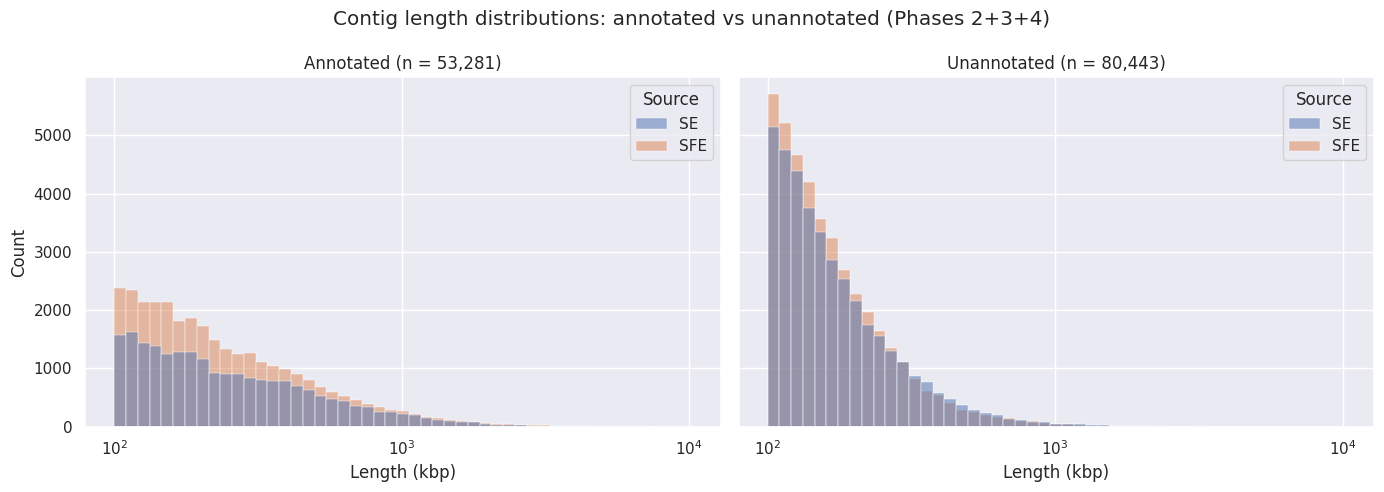

In [56]:
# Length distributions: annotated vs unannotated, split by SFE vs SE
rows = []
for s in any_annotation:
    if s in id_to_length:
        source = 'SFE' if s.startswith('SFE_') else 'SE'
        rows.append((id_to_length[s] / 1000, 'Annotated', source))
for s in none_annotated:
    if s in id_to_length:
        source = 'SFE' if s.startswith('SFE_') else 'SE'
        rows.append((id_to_length[s] / 1000, 'Unannotated', source))

df = pd.DataFrame(rows, columns = ['Length (kbp)', 'Status', 'Source'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), sharey = True)

bins = np.logspace(np.log10(100), np.log10(df['Length (kbp)'].max()), 50)

sns.histplot(data = df[df['Status'] == 'Annotated'], x = 'Length (kbp)', hue = 'Source',
             bins = bins, ax = ax1, edgecolor = 'white', linewidth = 0.3)
ax1.set_xscale('log')
ax1.set_title(f'Annotated (n = {len(df[df["Status"] == "Annotated"]):,})')

sns.histplot(data = df[df['Status'] == 'Unannotated'], x = 'Length (kbp)', hue = 'Source',
             bins = bins, ax = ax2, edgecolor = 'white', linewidth = 0.3)
ax2.set_xscale('log')
ax2.set_title(f'Unannotated (n = {len(df[df["Status"] == "Unannotated"]):,})')

fig.suptitle('Contig length distributions: annotated vs unannotated (Phases 2+3+4)')
plt.tight_layout()
plt.show()

In [57]:
# Phase 6: Coding density from pyrodigal gene predictions
# Parse GFF to compute coding density (fraction of contig covered by CDS) per contig
import re

coding_bp = {}   # contig_id -> total CDS bases
contig_len = {}  # contig_id -> sequence length (from GFF headers)

with open('Runs/taxonomy/SFE_SE_contigs.gff') as f:
    for line in f:
        if line.startswith('# Sequence Data:'):
            m = re.search(r'seqlen=(\d+);seqhdr="([^"]+)"', line)
            if m:
                cid = m.group(2)
                contig_len[cid] = int(m.group(1))
                coding_bp[cid] = 0
        elif not line.startswith('#'):
            parts = line.split('\t')
            if len(parts) >= 5 and parts[2] == 'CDS':
                coding_bp[parts[0]] = coding_bp.get(parts[0], 0) + int(parts[4]) - int(parts[3]) + 1

# Compute coding density for >= 100 kbp contigs
coding_density = {cid: coding_bp.get(cid, 0) / clen
                  for cid, clen in contig_len.items() if clen >= 100_000}

print(f'Contigs with coding density: {len(coding_density):,}')

# Load Tiara classifications
tiara_class = {}  # contig_id -> class (bacteria, archaea, eukarya, prokarya, unknown, organelle)
with open('Runs/taxonomy/tiara_output.tsv') as f:
    header = f.readline()
    for line in f:
        parts = line.strip().split('\t')
        tiara_class[parts[0]] = parts[1]

# Build combined dataframe with Tiara class and geNomad status
rows = []
for cid, cd in coding_density.items():
    tiara_cls = tiara_class.get(cid, 'unknown')
    is_virus = cid in virus_set
    is_plasmid = cid in plasmid_set
    in_graph = cid in graph_set
    rows.append((cid, cd, tiara_cls, is_virus, is_plasmid, in_graph))

cd_df = pd.DataFrame(rows, columns = ['contig_id', 'coding_density', 'tiara_class',
                                        'is_virus', 'is_plasmid', 
                                        'in_graph'])

# Summary statistics by Tiara class
print('\n=== Coding density by Tiara class ===')
for cls in ['bacteria', 'archaea', 'eukarya', 'prokarya', 'unknown', 'organelle']:
    sub = cd_df[cd_df['tiara_class'] == cls]['coding_density']
    print(f'  {cls:12s}: n={len(sub):6,}  median={sub.median():.3f}  '
          f'Q25={sub.quantile(0.25):.3f}  Q75={sub.quantile(0.75):.3f}')

# Giant virus candidates: Tiara eukarya + geNomad virus
euk = cd_df[cd_df['tiara_class'] == 'eukarya']
euk_virus = euk[euk['is_virus']]
euk_novirus = euk[~euk['is_virus']]
print(f'\n=== Eukarya subgroups ===')
print(f'  Euk + geNomad virus:  n={len(euk_virus):5,}  median={euk_virus["coding_density"].median():.3f}')
print(f'  Euk, not viral:       n={len(euk_novirus):5,}  median={euk_novirus["coding_density"].median():.3f}')

Contigs with coding density: 154,041

=== Coding density by Tiara class ===
  bacteria    : n=109,403  median=0.888  Q25=0.851  Q75=0.916
  archaea     : n= 5,352  median=0.890  Q25=0.853  Q75=0.917
  eukarya     : n=25,247  median=0.769  Q25=0.695  Q75=0.836
  prokarya    : n= 6,577  median=0.890  Q25=0.841  Q75=0.921
  unknown     : n= 6,963  median=0.853  Q25=0.795  Q75=0.896
  organelle   : n=   499  median=0.737  Q25=0.715  Q75=0.766

=== Eukarya subgroups ===
  Euk + geNomad virus:  n=5,542  median=0.870
  Euk, not viral:       n=19,705  median=0.748


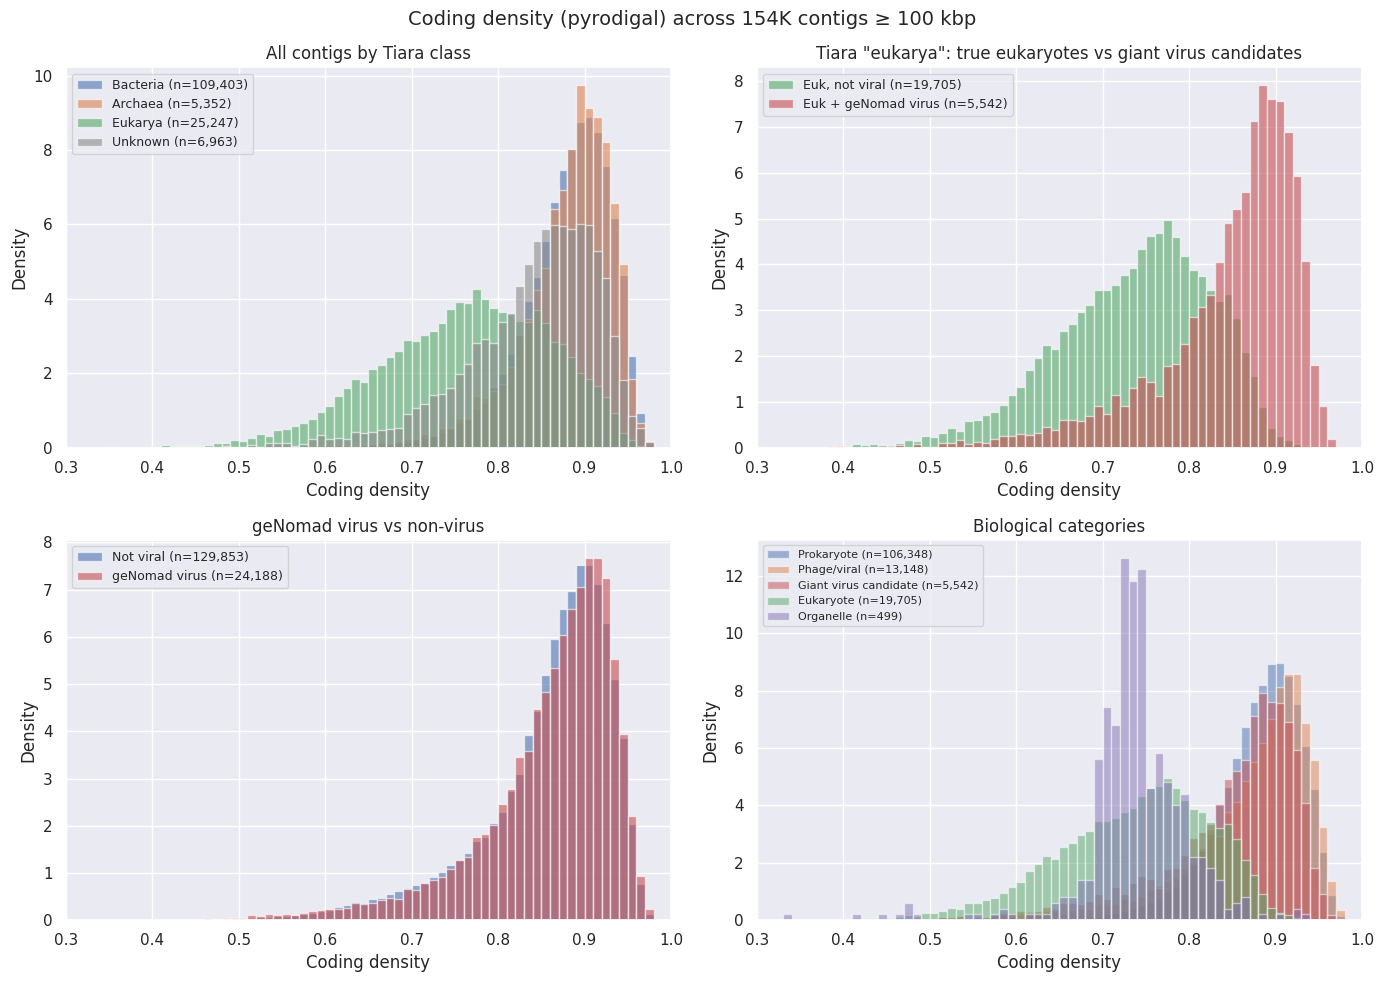

=== Key findings ===
Prokaryotes (not viral):     median 0.888  (n=106,348)
Phage/viral (prok host):     median 0.879  (n=24,188)
Giant virus candidates:      median 0.870  (n=5,542)
Eukaryotes (not viral):      median 0.748  (n=19,705)
Organelles:                  median 0.737  (n=499)


In [58]:
# Coding density distributions: prokaryotes vs eukaryotes vs giant virus candidates
fig, axes = plt.subplots(2, 2, figsize = (14, 10))


bins = np.linspace(0, 1, 101)

# Panel 1: All contigs by Tiara class
ax = axes[0, 0]
for cls, color, label in [('bacteria', 'C0', 'Bacteria'),
                           ('archaea', 'C1', 'Archaea'),
                           ('eukarya', 'C2', 'Eukarya'),
                           ('unknown', 'C7', 'Unknown')]:
    sub = cd_df[cd_df['tiara_class'] == cls]['coding_density']
    ax.hist(sub, bins = bins, alpha = 0.6, label = f'{label} (n={len(sub):,})',
            color = color, density = True)
ax.set_xlabel('Coding density')
ax.set_ylabel('Density')
ax.set_title('All contigs by Tiara class')
ax.legend(fontsize = 9)
ax.set_xlim(0.3, 1.0)

# Panel 2: Eukarya split by geNomad virus status
ax = axes[0, 1]
ax.hist(euk_novirus['coding_density'], bins = bins, alpha = 0.6, density = True,
        label = f'Euk, not viral (n={len(euk_novirus):,})', color = 'C2')
ax.hist(euk_virus['coding_density'], bins = bins, alpha = 0.6, density = True,
        label = f'Euk + geNomad virus (n={len(euk_virus):,})', color = 'C3')
ax.set_xlabel('Coding density')
ax.set_ylabel('Density')
ax.set_title('Tiara "eukarya": true eukaryotes vs giant virus candidates')
ax.legend(fontsize = 9)
ax.set_xlim(0.3, 1.0)

# Panel 3: geNomad virus vs non-virus (all contigs)
ax = axes[1, 0]
non_virus = cd_df[~cd_df['is_virus']]['coding_density']
is_virus = cd_df[cd_df['is_virus']]['coding_density']
ax.hist(non_virus, bins = bins, alpha = 0.6, density = True,
        label = f'Not viral (n={len(non_virus):,})', color = 'C0')
ax.hist(is_virus, bins = bins, alpha = 0.6, density = True,
        label = f'geNomad virus (n={len(is_virus):,})', color = 'C3')
ax.set_xlabel('Coding density')
ax.set_ylabel('Density')
ax.set_title('geNomad virus vs non-virus')
ax.legend(fontsize = 9)
ax.set_xlim(0.3, 1.0)

# Panel 4: Five biological categories
ax = axes[1, 1]
categories = [
    ('Prokaryote', cd_df[cd_df['tiara_class'].isin(['bacteria', 'archaea']) & ~cd_df['is_virus']], 'C0'),
    ('Phage/viral', cd_df[cd_df['tiara_class'].isin(['bacteria', 'archaea', 'prokarya']) & cd_df['is_virus']], 'C1'),
    ('Giant virus candidate', cd_df[(cd_df['tiara_class'] == 'eukarya') & cd_df['is_virus']], 'C3'),
    ('Eukaryote', cd_df[(cd_df['tiara_class'] == 'eukarya') & ~cd_df['is_virus']], 'C2'),
    ('Organelle', cd_df[cd_df['tiara_class'] == 'organelle'], 'C4'),
]
for label, sub, color in categories:
    if len(sub) > 0:
        ax.hist(sub['coding_density'], bins = bins, alpha = 0.5, density = True,
                label = f'{label} (n={len(sub):,})', color = color)
ax.set_xlabel('Coding density')
ax.set_ylabel('Density')
ax.set_title('Biological categories')
ax.legend(fontsize = 8)
ax.set_xlim(0.3, 1.0)

fig.suptitle('Coding density (pyrodigal) across 154K contigs ≥ 100 kbp', fontsize = 14)
plt.tight_layout()
plt.show()

# Print key numbers
print('=== Key findings ===')
prok = cd_df[cd_df['tiara_class'].isin(['bacteria', 'archaea']) & ~cd_df['is_virus']]
print(f'Prokaryotes (not viral):     median {prok["coding_density"].median():.3f}  (n={len(prok):,})')
print(f'Phage/viral (prok host):     median {is_virus.median():.3f}  (n={len(is_virus):,})')
gv = cd_df[(cd_df['tiara_class'] == 'eukarya') & cd_df['is_virus']]
print(f'Giant virus candidates:      median {gv["coding_density"].median():.3f}  (n={len(gv):,})')
print(f'Eukaryotes (not viral):      median {euk_novirus["coding_density"].median():.3f}  (n={len(euk_novirus):,})')
org = cd_df[cd_df['tiara_class'] == 'organelle']
print(f'Organelles:                  median {org["coding_density"].median():.3f}  (n={len(org):,})')